<a href="https://colab.research.google.com/github/orellanomariana/proyecto_DS3/blob/main/DS3_PROYECTO_FINAL_MARIANA_ORELLANO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

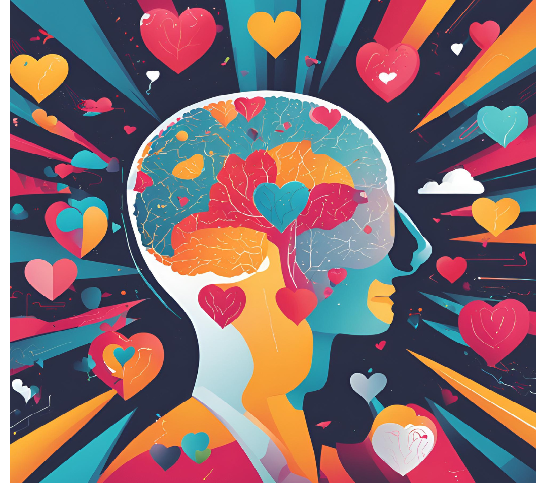

# **De las Palabras a las Emociones 📖➡️❤️**
**Un Enfoque NLP para el Análisis de Sentimientos**


Este proyecto tiene como objetivo desarrollar un analizador de sentimientos de texto.
Se explorarán diferentes estrategias de preprocesamiento de datos, incluyendo técnicas como lemmatización, stemming y n-gramas.
Se evaluarán distintos algoritmos de clasificación, como regresión logística y random forest, ajustando sus hiperparámetros para optimizar el rendimiento.

El punto de partida es un dataset obtenido de Kaggle (https://www.kaggle.com/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset/data),
que contiene un conjunto de 3.309 oraciones categorizadas en dos sentimientos principales:

- Positivo: 1.679 muestras  
- Negativo: 1.630 muestras

El enfoque principal será comparar estas alternativas en busca de la mejor performance, medida principalmente en términos de su accuracy. Este análisis permitirá identificar el camino más
efectivo para realizar análisis de sentimiento en este conjunto de datos.





#Librerias necesarias

In [ ]:
import pandas as pd
import plotly.express as px
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix





In [ ]:
!pip install nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

#Carga del dataset

In [ ]:
url = "https://raw.githubusercontent.com/orellanomariana/proyecto_DS3/refs/heads/main/00_datasets/combined_sentiment_data.csv"
df = pd.read_csv(url)
df

,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive
...,...,...
3304,Online anonymity enables freedom of expression...,negative
3305,Smart cities leverage data and technology to i...,positive
3306,Biometric identification technologies offer co...,negative
3307,Data ethics guidelines are essential for ensur...,positive


#Analisis inicial de los datos

In [ ]:
df['sentiment'].unique()

array(['negative', 'positive'], dtype=object)

In [ ]:
text_column = 'sentence'
label_column = 'sentiment'


In [ ]:
df

,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive
...,...,...
3304,Online anonymity enables freedom of expression...,negative
3305,Smart cities leverage data and technology to i...,positive
3306,Biometric identification technologies offer co...,negative
3307,Data ethics guidelines are essential for ensur...,positive


In [ ]:
df['words_per_sentence'] = df['sentence'].apply(lambda x: len(x.split(" ")))
df['word_range'] = pd.cut(df['words_per_sentence'], bins=[0, 10, 20, 30, float('inf')], labels=['0-10', '10-20', '20-30', '30+'])
df['word_range'] = pd.Categorical(df['word_range'], categories=['0-10', '10-20', '20-30', '30+'], ordered=True)
fig = px.histogram(
    df,
    x='word_range',
    title='Número de palabras por comentario',
    labels={'word_range': 'Rango de palabras'},
    color='word_range',
    color_discrete_map={'0-10': '#D92B6B', '10-20': '#30BFBF', '20-30': '#F28F38', '30+': '#F27141'},
    template='plotly_white',
    category_orders={'word_range': ['0-10', '10-20', '20-30', '30+']}  # Controlar el orden de las categorías
)

fig.update_layout(
    xaxis_title='Rango de palabras',
    yaxis_title='Frecuencia',
    title_x=0.5,
    font=dict(size=14),
    height=400,
    width=600,
    legend=dict(
        traceorder='normal',
        title="Rango de palabras",
        itemclick="toggleothers"
    )
)
fig.show()





In [ ]:
mean_words = df['words_per_sentence'].mean()
mean_words_rounded = round(mean_words, 0)
print(f"Media de palabras por oración (redondeada): {mean_words_rounded}")


Media de palabras por oración (redondeada): 13.0


#Nube de palabras

224110


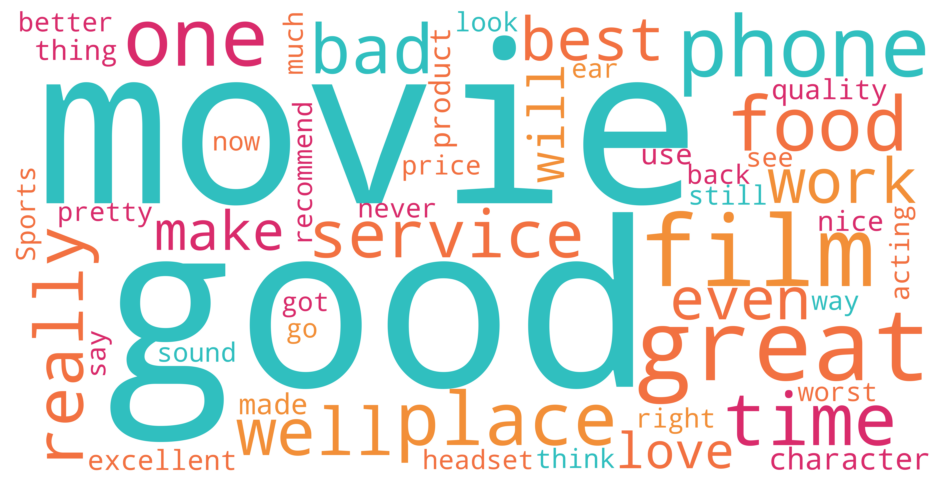

In [ ]:

color_palette = ['#D92B6B', '#30BFBF', '#F28F38', '#F27141']
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(color_palette)
word_cloud_text = ''.join(df.sentence)
print(len(word_cloud_text))
wordcloud = WordCloud(
    max_font_size=200,
    max_words=50,
    background_color="white",
    scale=10,
    width=800,
    height=400,
    color_func=color_func
    ).generate(word_cloud_text)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


A partir del análisis preliminar de los datos, se observaron los siguientes aspectos:

* Las etiquetas disponibles están categorizadas en dos clases principales:
positive y negative.
* Se definieron dos variables principales para el análisis: text, que contiene las oraciones, y label, que representa las categorías asignadas.
* En promedio, las oraciones tienen 13 palabras, con la mayoría de ellas comprendidas en el rango de 1 a 10 palabras.
* Se generó una nube de palabras para visualizar de manera gráfica los términos que aparecen con mayor frecuencia en el texto.

Con esta información inicial, se procede a aplicar técnicas de preprocesamiento para preparar los datos para el modelado y análisis posterior.

#Preprocesamiento

In [ ]:
#Limpieza de texto con regex
def limpiar_texto(texto):
    texto = re.sub(r"http\S+", "", texto)  # Eliminar URLs
    texto = re.sub(r"@\w+", "", texto)  # Eliminar menciones
    texto = re.sub(r"#\w+", "", texto)  # Eliminar hashtags
    texto = re.sub(r"[^a-zA-Z\s]", "", texto)  # Eliminar caracteres no alfabéticos
    texto = texto.lower()  # Convertir a minúsculas
    texto = texto.strip()  # Eliminar espacios extra
    return texto

df[text_column] = df[text_column].apply(limpiar_texto)

In [ ]:
# eliminar stopwords de la libreria nltk y palabras de alta y baja frecuencia, armado de noise words

nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words


179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
token_lists_original = [word_tokenize(each) for each in df['sentence']]
tokens = [item for sublist in token_lists_original for item in sublist]


In [ ]:
#Elimino las palabras de alta frecuencia
from collections import Counter
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('the', 2119),
 ('and', 1351),
 ('a', 937),
 ('i', 887),
 ('is', 798),
 ('to', 771),
 ('of', 762),
 ('it', 669),
 ('this', 639),
 ('was', 569)]

In [ ]:
#y las de baja frecuencia
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('mars', 1),
 ('represent', 1),
 ('overcoming', 1),
 ('technical', 1),
 ('colonies', 1),
 ('expanding', 1),
 ('phenomena', 1),
 ('solar', 1),
 ('flares', 1),
 ('geomagnetic', 1)]

In [ ]:
#sumar palabras de alta  y baja frecuencia a la noise_words
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [ ]:
# Tokenización y lematización con spaCy y aplica stop words de spacy
nlp = spacy.load("en_core_web_sm")

def tokenizar_lematizar(texto):
    doc = nlp(texto)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

df['processed_text'] = df[text_column].apply(tokenizar_lematizar)

In [ ]:
df

,sentence,sentiment,words_per_sentence,word_range,processed_text
0,so there is no way for me to plug it in here i...,negative,21,20-30,way plug converter
1,good case excellent value,positive,4,0-10,good case excellent value
2,great for the jawbone,positive,4,0-10,great jawbone
3,tied to charger for conversations lasting more...,negative,11,10-20,tie charger conversation last minutesmajor p...
4,the mic is great,positive,4,0-10,mic great
...,...,...,...,...,...
3304,online anonymity enables freedom of expression...,negative,12,10-20,online anonymity enable freedom expression fac...
3305,smart cities leverage data and technology to i...,positive,18,10-20,smart cities leverage datum technology improve...
3306,biometric identification technologies offer co...,negative,14,10-20,biometric identification technology offer conv...
3307,data ethics guidelines are essential for ensur...,positive,13,10-20,datum ethic guideline essential ensure respons...


In [ ]:
#Crear n-gramas y matriz de características
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Unigramas y bigramas
X = vectorizer.fit_transform(df['processed_text'])

X

<3309x18321 sparse matrix of type '<class 'numpy.int64'>'
	with 33136 stored elements in Compressed Sparse Row format>

In [ ]:
print("Shape de la matriz de características:", X.shape)


Shape de la matriz de características: (3309, 18321)


In [ ]:
# Crear un vectorizador con tokenización personalizada y excluyendo palabras de ruido
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 2)
)


X = bow_counts.fit_transform(df['processed_text'])


print("Términos:", bow_counts.get_feature_names_out())


Términos: ['aailiyah' 'aailiyah pretty' 'abandon' ... 'zombiestudent human'
 'zombiez' 'zombiez hellish']


In [ ]:
# Convertir la matriz BoW a DataFrame para visualización
bow_df = pd.DataFrame(X.toarray(), columns=bow_counts.get_feature_names_out())

# Mostrar las primeras filas
print(bow_df.head())

   aailiyah  aailiyah pretty  abandon  abandon factory  abhor  ability  \
0         0                0        0                0      0        0   
1         0                0        0                0      0        0   
2         0                0        0                0      0        0   
3         0                0        0                0      0        0   
4         0                0        0                0      0        0   

   ability actually  ability dwight  ability meld  ability potential  ...  \
0                 0               0             0                  0  ...   
1                 0               0             0                  0  ...   
2                 0               0             0                  0  ...   
3                 0               0             0                  0  ...   
4                 0               0             0                  0  ...   

   zero  zero star  zero taste  zillion  zillion away  zombie  zombiestudent  \
0     0     

# Resumen del Preprocesamiento realizado

* Limpieza inicial de texto:

Se aplicaron técnicas de limpieza utilizando expresiones regulares (regex) para eliminar caracteres especiales, números, y otros elementos innecesarios del texto.

* Generación de "noise words" (palabras que generan ruido):

Se identificaron palabras de alta y baja frecuencia: el 1% más frecuente y el 1% menos frecuente en el corpus.
Se utilizaron las stopwords predefinidas de la librería NLTK, que fueron complementadas con las palabras identificadas como ruido.

* Tokenización y lematización:

Se procesaron los textos con spaCy, utilizando su lista de stopwords para eliminar términos irrelevantes.
Este paso generó una nueva columna en el DataFrame llamada processed_text, que contiene el texto limpio, tokenizado y lematizado.

* Construcción de n-gramas:

A partir de la columna processed_text, se generaron unigramas y bigramas.
Esto resultó en una matriz de características con dimensiones (3309, 18321).

* Creación de la Bolsa de Palabras (BoW):

Se utilizó el método CountVectorizer para generar la matriz de características basada en la frecuencia de los términos.
Se emplearon las palabras definidas en el conjunto noise words como stopwords para mejorar la calidad del modelo.

Este paso generó el conjunto X, que será utilizado para entrenar los algoritmos de clasificación.

#Modelos de clasificacion : Regresion Logistica y Random Forest Classifier

In [ ]:

X = bow_counts.fit_transform(df['processed_text'])
y = df['sentiment']

# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Entrenar los modelos de clasificación

# Modelo 1: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

# Modelo 2: Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)


# métricas de accuracy de cada modelo
print("Accuracy del modelo Logistic Regression:", logreg_accuracy)
print("Accuracy del modelo Random Forest:", rf_accuracy)




Accuracy del modelo Logistic Regression: 0.7507552870090635
Accuracy del modelo Random Forest: 0.7356495468277946


Tras realizar el preprocesamiento inicial, se entrenaron dos modelos de clasificación: Regresión Logística y Random Forest. Los resultados obtenidos mostraron un accuracy del 75% y 73%, respectivamente. Con el objetivo de optimizar el desempeño de los modelos, se explorarán mejoras en el preprocesamiento y se evaluarán alternativas que permitan incrementar su precisión y efectividad

#Mejora del preprocesamiento


#TF-IDF y trigramas

Voy a generar una matriz de características denominada X_preprocesada, mejorando el preprocesamiento al incorporar trigramas y aplicar la técnica de ponderación TF-IDF (Term Frequency-Inverse Document Frequency). Este enfoque captura mejor la importancia relativa de las palabras y combinaciones de palabras (unigramas, bigramas y trigramas) dentro del texto, destacando aquellas que son más representativas para la clasificación. Posteriormente, entrenaré los mismos modelos (Logistic Regression y Random Forest) utilizando esta nueva representación y compararé los valores de accuracy obtenidos antes y después de esta mejora, evaluando el impacto del preprocesamiento avanzado

In [ ]:
# Mejora del preprocesamiento con TF-IDF y trigramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
X_preprocesada = tfidf_vectorizer.fit_transform(df['processed_text'])

# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(X_preprocesada, y, test_size=0.2, random_state=42)


# Modelo 1: Logistic Regression
logreg_prep = LogisticRegression(max_iter=1000)
logreg_prep.fit(X_train_prep, y_train_prep)
y_pred_logreg_prep = logreg_prep.predict(X_test_prep)
logreg_accuracy_prep = accuracy_score(y_test_prep, y_pred_logreg_prep)

# Modelo 2: Random Forest
rf_prep = RandomForestClassifier(n_estimators=100)
rf_prep.fit(X_train_prep, y_train_prep)
y_pred_rf_prep = rf_prep.predict(X_test_prep)
rf_accuracy_prep = accuracy_score(y_test_prep, y_pred_rf_prep)

print("\nResultados con mejora del preprocesamiento:")
print("Accuracy del modelo Logistic Regression (con mejora):", logreg_accuracy_prep)
print("Accuracy del modelo Random Forest (con mejora):", rf_accuracy_prep)




Resultados con mejora del preprocesamiento:
Accuracy del modelo Logistic Regression (con mejora): 0.7990936555891238
Accuracy del modelo Random Forest (con mejora): 0.8081570996978852


In [ ]:
# Comparacion grafica
data = {
    "Modelo": ["Logistic Regression", "Logistic Regression", "Random Forest", "Random Forest"],
    "Preprocesamiento": ["Original", "Mejorado", "Original", "Mejorado"],
    "Accuracy": [logreg_accuracy, logreg_accuracy_prep, rf_accuracy, rf_accuracy_prep],
}

df_results = pd.DataFrame(data)
fig = px.bar(
    df_results,
    x="Modelo",
    y="Accuracy",
    color="Preprocesamiento",
    barmode="group",
    text="Accuracy",
    title="Comparación de Accuracy entre Preprocesamientos",
    labels={"Accuracy": "Accuracy", "Modelo": "Modelo", "Preprocesamiento": "Preprocesamiento"},
    color_discrete_sequence=['#D92B6B', '#30BFBF', '#F28F38', '#F27141'],
)

fig.update_traces(
    texttemplate='%{text:.4f}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=1.5
)

fig.update_layout(
    title=dict(
        text="📊 Comparación de Accuracy: Original vs Mejorado",
        x=0.5,
        font=dict(size=20, color='darkblue'),
        y=0.97
    ),
    xaxis=dict(
        title="Modelo",
        tickfont=dict(size=14),
        title_font=dict(size=16)
    ),
    yaxis=dict(
        title="Accuracy",
        title_font=dict(size=16),
        tickfont=dict(size=14),
        gridcolor='lightgrey',
        range=[0, 1]
    ),
    plot_bgcolor='rgba(245, 245, 245, 0.9)',
    legend=dict(
        title="Preprocesamiento",
        font=dict(size=14),
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="center",
        x=0.5
    ),
    font=dict(family="Arial", size=14),
    margin=dict(
        t=100,
        b=40,
        l=80,
        r=80
    ),
    width=800,
    height=500
)

fig.add_shape(
    type="line",
    x0=-0.5, x1=3.5, y0=0.75, y1=0.75,
    line=dict(color="red", width=2, dash="dash"),
    xref="x", yref="y"
)

fig.add_annotation(
    x=1.5, y=0.76,
    text="Nivel deseado: 75%",
    showarrow=False,
    font=dict(size=12, color="red"),
    align="center",
    bgcolor="white",
    bordercolor="red",
    borderwidth=1,
    borderpad=4
)

fig.update_layout(
    title=dict(
        text="📊 Comparación de Accuracy: Original vs Mejorado",
        x=0.5,
        font=dict(size=20, color='darkblue'),
        y=0.93  # Ajusta la posición vertical del título para darle más espacio
    ),
    xaxis=dict(
        title="Modelo",
        tickfont=dict(size=14),
        title_font=dict(size=16)
    ),
    yaxis=dict(
        title="Accuracy",
        title_font=dict(size=16),
        tickfont=dict(size=14),
        gridcolor='lightgrey',
        range=[0, 1]
    ),
    plot_bgcolor='rgba(245, 245, 245, 0.9)',
    legend=dict(
        title="Preprocesamiento",
        font=dict(size=14),
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="center",
        x=0.5
    ),
    font=dict(family="Arial", size=14),
    margin=dict(
        t=140,  # Aumenta el margen superior para evitar la superposición con la línea y el texto
        b=40,
        l=80,
        r=80
    ),
    width=800,
    height=500
)

fig.show()



#Ajuste de hiperparámetros con GridSearchCV

Busco mejora de hiperparametros de los dos modelos y aplico sobre la X_preprocesada, es decir luego de la mejora del preprocesamiento

In [ ]:


# Parámetros para Logistic Regression
logreg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [1000, 2000, 3000]
}


# Parámetros para Random Forest
rf_params = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [5, 8],
    'min_samples_leaf': [2, 3],
    'bootstrap': [True]
}


# GridSearchCV para Logistic Regression
logreg_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=logreg_params, cv=5, n_jobs=-1)
logreg_grid.fit(X_train_prep, y_train_prep)

# GridSearchCV para Random Forest
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train_prep, y_train_prep)

# Mejor modelo para Logistic Regression
logreg_best = logreg_grid.best_estimator_
logreg_best_accuracy = accuracy_score(y_test_prep, logreg_best.predict(X_test_prep))

# Mejor modelo para Random Forest
rf_best = rf_grid.best_estimator_
rf_best_accuracy = accuracy_score(y_test_prep, rf_best.predict(X_test_prep))

# Resultados finales
print("\nMejores resultados con GridSearchCV:")
print("Mejor Accuracy para Logistic Regression (con ajuste de hiperparámetros):", logreg_best_accuracy)
print("Mejor Accuracy para Random Forest (con ajuste de hiperparámetros):", rf_best_accuracy)

# Mostrar los mejores hiperparámetros
print("\nMejores hiperparámetros para Logistic Regression:", logreg_grid.best_params_)
print("Mejores hiperparámetros para Random Forest:", rf_grid.best_params_)



Mejores resultados con GridSearchCV:
Mejor Accuracy para Logistic Regression (con ajuste de hiperparámetros): 0.7990936555891238
Mejor Accuracy para Random Forest (con ajuste de hiperparámetros): 0.7824773413897281

Mejores hiperparámetros para Logistic Regression: {'C': 1, 'max_iter': 2000, 'solver': 'saga'}
Mejores hiperparámetros para Random Forest: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


No obtengo resultados que mejoren considerablemente el accuracy

# Implementación de otros modelos

Evaluación de la performance de dos modelos adicionales, Naive Bayes y XGBoost, los cuales podrían generar mejores resultados en comparación con los modelos previamente evaluados.

##Naive Bayes

In [ ]:

nb = MultinomialNB()
nb.fit(X_train_prep, y_train_prep) #CON LAS MEJORAS DE PREPROCESAMIENTO


y_pred_nb = nb.predict(X_test_prep)


nb_accuracy = accuracy_score(y_test_prep, y_pred_nb)
print("Accuracy del modelo Naive Bayes:", nb_accuracy)



Accuracy del modelo Naive Bayes: 0.8006042296072508


##XGBoost

In [ ]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_prep)
y_test_encoded = label_encoder.transform(y_test_prep)

print("Clases originales:", label_encoder.classes_)
print("Etiquetas codificadas:", set(y_train_encoded))



Clases originales: ['negative' 'positive']
Etiquetas codificadas: {0, 1}


In [ ]:

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_prep, y_train_encoded)

y_pred_xgb = xgb.predict(X_test_prep)

xgb_accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print("Accuracy del modelo XGBoost:", xgb_accuracy)



Accuracy del modelo XGBoost: 0.8036253776435045


In [ ]:
import pandas as pd
import plotly.express as px

# Datos para el gráfico
data = {
    "Modelo": ["Logistic Regression", "Random Forest", "Naive Bayes", "XGBoost"],
    "Accuracy": [logreg_accuracy_prep, rf_accuracy_prep, nb_accuracy, xgb_accuracy],
}

df_results = pd.DataFrame(data)
fig = px.bar(
    df_results,
    x="Modelo",
    y="Accuracy",
    text="Accuracy",
    title="Comparación de Accuracy de Modelos Después de la Mejora de Preprocesamiento",
    labels={"Accuracy": "Accuracy", "Modelo": "Modelo"},
    color="Modelo",
    color_discrete_sequence=['#D92B6B', '#30BFBF', '#F28F38', '#F27141'],
)

fig.update_traces(
    texttemplate='%{text:.4f}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=1.5
)

fig.update_layout(
    title=dict(
        text="📊 Comparación de Accuracy de Modelos Después de la Mejora de Preprocesamiento",
        x=0.5,
        font=dict(size=20, color='darkblue')
    ),
    xaxis=dict(
        title="Modelo",
        tickfont=dict(size=14),
        title_font=dict(size=16)
    ),
    yaxis=dict(
        title="Accuracy",
        title_font=dict(size=16),
        tickfont=dict(size=14),
        gridcolor='lightgrey',
    ),
    plot_bgcolor='rgba(245, 245, 245, 0.9)',
    legend=dict(
        title="Modelo",
        font=dict(size=14),
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    font=dict(family="Arial", size=14),
    margin=dict(
        t=100,
        b=40,
        l=80,
        r=80
    ),
    width=800,
    height=500  ,
)

fig.update_layout(
    yaxis=dict(
        range=[0.79, 0.81],
    )
)

fig.show()


Luego de realizar mejoras en el preprocesamiento inicial y comparar cuatro modelos (Regresión Logística, Random Forest, Naive Bayes y XGBoost), llegué a la conclusión de que, tras aplicar técnicas de lematización junto con mejoras posteriores como trigramas y la técnica de TF-IDF, el modelo que mejor desempeño mostró fue el Random Forest, con un accuracy de 0.8082. El siguiente paso será aplicar Stemming y comparar los resultados obtenidos para determinar si esta técnica mejora aún más el rendimiento del modelo

#Stemming

In [ ]:
# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm')

# Inicializar el stemmer de NLTK
stemmer = PorterStemmer()

# Función para preprocesar el texto
def preprocess_text(text, stopwords_spacy, min_freq=5):

    text = text.lower()

    # Procesar el texto con spaCy (tokenización y stopwords)
    doc = nlp(text)

    # Eliminar stopwords y seleccionar palabras alfabéticas
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]

    # Aplicar stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(stemmed_tokens)

# Filtrar las palabras de alta frecuencia (aparece en más del 5% de los documentos)
def remove_high_freq_words(texts, min_freq=5):
    all_tokens = [word_tokenize(text.lower()) for text in texts]

    word_counts = Counter([item for sublist in all_tokens for item in sublist])

    # Filtrar las palabras que aparecen en menos del umbral mínimo de frecuencia
    words_to_remove = {word for word, count in word_counts.items() if count > min_freq}
    return words_to_remove


high_freq_words = remove_high_freq_words(df['sentence'])

# Filtrar el texto aplicando stopwords y alta frecuencia
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS
df['processed_text_stemming'] = df['sentence'].apply(lambda x: preprocess_text(x, stopwords_spacy, high_freq_words))

# Verificar el resultado del preprocesamiento
df



,sentence,sentiment,words_per_sentence,word_range,processed_text,processed_text_stemming
0,so there is no way for me to plug it in here i...,negative,21,20-30,way plug converter,way plug convert
1,good case excellent value,positive,4,0-10,good case excellent value,good case excel valu
2,great for the jawbone,positive,4,0-10,great jawbone,great jawbon
3,tied to charger for conversations lasting more...,negative,11,10-20,tie charger conversation last minutesmajor p...,tie charger convers last minutesmajor problem
4,the mic is great,positive,4,0-10,mic great,mic great
...,...,...,...,...,...,...
3304,online anonymity enables freedom of expression...,negative,12,10-20,online anonymity enable freedom expression fac...,onlin anonym enabl freedom express facilit cyb...
3305,smart cities leverage data and technology to i...,positive,18,10-20,smart cities leverage datum technology improve...,smart citi leverag data technolog improv urban...
3306,biometric identification technologies offer co...,negative,14,10-20,biometric identification technology offer conv...,biometr identif technolog offer conveni secur ...
3307,data ethics guidelines are essential for ensur...,positive,13,10-20,datum ethic guideline essential ensure respons...,data ethic guidelin essenti ensur respons equi...


In [ ]:

vectorizer = CountVectorizer(ngram_range=(1, 3))  # Unigramas,bigramas y trigramas
X = vectorizer.fit_transform(df['processed_text_stemming'])  # Transformar el texto preprocesado
y = df['sentiment']
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Regresión Logística
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logreg_accuracy_stemm = accuracy_score(y_test, y_pred_logreg)
print("Accuracy Regresión Logística:", logreg_accuracy_stemm )

# Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy_stemm= accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest:", rf_accuracy_stemm)




Accuracy Regresión Logística: 0.8202416918429003
Accuracy Random Forest: 0.7870090634441088


#Mejorar preprocesamiento

In [ ]:

# Función para limpiar el texto profundamente
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)  # Eliminar menciones
    text = re.sub(r'#\w+', '', text)  # Eliminar hashtags
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales
    return text.lower()

# Filtrar palabras raras
def remove_low_freq_words(texts, min_freq=3):
    all_tokens = [word for text in texts for word in word_tokenize(text)]
    word_counts = Counter(all_tokens)
    rare_words = {word for word, count in word_counts.items() if count < min_freq}
    return rare_words

# Aplicar limpieza de texto profundamente
df['cleaned_text'] = df['sentence'].apply(clean_text)

# Identificar palabras raras
rare_words = remove_low_freq_words(df['cleaned_text'], min_freq=3)

# Filtrar palabras raras de cada texto
df['filtered_text'] = df['cleaned_text'].apply(
    lambda text: ' '.join([word for word in word_tokenize(text) if word not in rare_words])
)

# Generar representación n-gramas
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english')
X_ngram = vectorizer.fit_transform(df['filtered_text'])

df.head()


,sentence,sentiment,words_per_sentence,word_range,processed_text,processed_text_stemming,cleaned_text,filtered_text
0,so there is no way for me to plug it in here i...,negative,21,20-30,way plug converter,way plug convert,so there is no way for me to plug it in here i...,so there is no way for me to plug it in here i...
1,good case excellent value,positive,4,0-10,good case excellent value,good case excel valu,good case excellent value,good case excellent value
2,great for the jawbone,positive,4,0-10,great jawbone,great jawbon,great for the jawbone,great for the jawbone
3,tied to charger for conversations lasting more...,negative,11,10-20,tie charger conversation last minutesmajor p...,tie charger convers last minutesmajor problem,tied to charger for conversations lasting more...,to charger for conversations lasting more than...
4,the mic is great,positive,4,0-10,mic great,mic great,the mic is great,the mic is great


In [ ]:
ngram_df = pd.DataFrame(X_ngram.toarray(), columns=vectorizer.get_feature_names_out())
ngram_df.head()


,ability,ability actually,ability actually know,ability highly,ability highly creativity,ability phone,ability pull,able,able house,able house phone,...,youre served nice,yummy,yummy christmas,yummy christmas dinner,yummy try,zero,zero stars,zero stars possible,zero stars zero,zero taste
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# Dividir los datos en entrenamiento y prueba
X_train_mejora, X_test_mejora, y_train_mejora, y_test_mejora = train_test_split(X_ngram, df['sentiment'], test_size=0.3, random_state=42)

# Regresión Logística
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_mejora, y_train_mejora)

# Predicciones y precisión para Regresión Logística
logreg_predictions = logreg_model.predict(X_test_mejora)
logreg_accuracy_mejora = accuracy_score(y_test_mejora, logreg_predictions)
print(f"Accuracy de Regresión Logística: {logreg_accuracy_mejora}")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_mejora, y_train_mejora)

# Predicciones y precisión para Random Forest
rf_predictions = rf_model.predict(X_test_mejora)
rf_accuracy_mejora = accuracy_score(y_test_mejora, rf_predictions)
print(f"Accuracy de Random Forest: {rf_accuracy_mejora}")


Accuracy de Regresión Logística: 0.7945619335347432
Accuracy de Random Forest: 0.7633434038267876


# Comparacion de resultados

In [ ]:
# Datos para el gráfico
data = {
    "Modelo": ["Logistic Regression", "Logistic Regression+Mejora", "Random Forest", "Random Forest+Mejora"],
    "Accuracy": [logreg_accuracy_stemm, logreg_accuracy_mejora, rf_accuracy_stemm, rf_accuracy_mejora],
}

df_results = pd.DataFrame(data)

fig = px.bar(
    df_results,
    x="Modelo",
    y="Accuracy",
    color="Modelo",
    barmode="group",
    text="Accuracy",
    title="Comparación de Accuracy Stemming + mejoras",
    labels={"Accuracy": "Accuracy", "Modelo": "Modelo"},
    color_discrete_sequence=['#D92B6B', '#30BFBF', '#F28F38', '#F27141'],
)


fig.update_traces(
    texttemplate='%{text:.4f}',
    textposition='outside',
    marker_line_color='black',  #
    marker_line_width=1.5
)

fig.update_layout(
    title=dict(
        text="📊 Comparación de Accuracy Stemming + mejoras",
        x=0.5,
        font=dict(size=20, color='darkblue'),
        y=0.97
    ),
    xaxis=dict(
        title="Modelo",
        tickfont=dict(size=14),
        title_font=dict(size=12),
        tickangle=0,
    ),
    yaxis=dict(
        title="Accuracy",
        title_font=dict(size=10),
        tickfont=dict(size=16),
        gridcolor='lightgrey',
        range=[0.7, 0.85]
    ),

    font=dict(family="Arial", size=14),
    margin=dict(
        t=100,
        b=80,
        l=100,
        r=100
    ),


)

fig.show()


# Validacion del modelo seleccionado

In [ ]:
# Validación Cruzada (Cross Validation)
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')  # Validación cruzada de 5 pliegues
print(f"Accuracy Promedio en Validación Cruzada: {cv_scores.mean():.4f}")

# Entrenamos el modelo sobre todo el conjunto de entrenamiento
logreg.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred_logreg = logreg.predict(X_test)

# Calcular Accuracy
logreg_accuracy_stemm = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy Regresión Logística en Test Set: {logreg_accuracy_stemm:.4f}")

# Generar la Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_logreg)

# Convertir la matriz de confusión en un DataFrame para utilizar con Plotly
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicción 0', 'Predicción 1'],
                              index=['Real 0', 'Real 1'])

# Crear gráfico de la matriz de confusión con Plotly Express
fig = px.imshow(conf_matrix_df,
                text_auto=True,
                labels={'x': 'Predicción', 'y': 'Real'},
                title='Matriz de Confusión - Regresión Logística')

# Aplicar color_discrete_sequence personalizado usando coloraxis
fig.update_traces(
    coloraxis="coloraxis",
    textfont=dict(family="Arial", size=18, color="white", weight="bold")  # Números en blanco y en negrita
)

# Ajustar el coloraxis para usar la secuencia de colores personalizada
fig.update_layout(
    coloraxis=dict(colorscale=['#D92B6B', '#30BFBF', '#F28F38', '#F27141']),
    xaxis_title='Predicción',
    yaxis_title='Real',
    title_x=0.5,  # Centrar el título
    title_font=dict(size=20, color='darkblue'),
    font=dict(family="Arial", size=14),
)

fig.show()

Accuracy Promedio en Validación Cruzada: 0.7941
Accuracy Regresión Logística en Test Set: 0.8202


# Conclusion Final algoritmos de ML para Analisis de sentimiento

Este modelo de regresión logística ha demostrado ser el de mejor rendimiento entre los evaluados, alcanzando una precisión del 82.02% en el conjunto de prueba, lo que refleja su capacidad para clasificar correctamente la mayoría de los casos. A pesar de algunos errores (59 falsos positivos y 60 falsos negativos) según la matriz de confusión, su desempeño general es sólido, con un accuracy promedio de 79.41% en validación cruzada, lo que muestra su estabilidad al ser evaluado en diferentes subconjuntos de los datos. Estos resultados sugieren que el modelo es equilibrado y eficaz, superando a otros modelos en términos de precisión y consistencia. Tras haber explorado diversas alternativas en cuanto a preprocesamiento, selección de modelos y ajuste de hiperparámetros, concluyo este proyecto con la elección de este modelo como la mejor opción para desarrollar un analizador de sentimientos de texto.

# 🤖 Redes Neuronales: ¡Me la juego! Lo intento a ver qué sale 💪✨

In [ ]:
#carga librerias

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
import tensorflow as tf
# Fijar la semilla para NumPy, TensorFlow y Python

random.seed(42)
tf.random.set_seed(42)

In [ ]:
df.head()

,sentence,sentiment,words_per_sentence,word_range,processed_text,processed_text_stemming,cleaned_text,filtered_text
0,so there is no way for me to plug it in here i...,negative,21,20-30,way plug converter,way plug convert,so there is no way for me to plug it in here i...,so there is no way for me to plug it in here i...
1,good case excellent value,positive,4,0-10,good case excellent value,good case excel valu,good case excellent value,good case excellent value
2,great for the jawbone,positive,4,0-10,great jawbone,great jawbon,great for the jawbone,great for the jawbone
3,tied to charger for conversations lasting more...,negative,11,10-20,tie charger conversation last minutesmajor p...,tie charger convers last minutesmajor problem,tied to charger for conversations lasting more...,to charger for conversations lasting more than...
4,the mic is great,positive,4,0-10,mic great,mic great,the mic is great,the mic is great


In [ ]:
# x contiene el texto preprocesado
x = df['processed_text_stemming']  # Uso la columna de texto procesado con stemming
y = df['sentiment']


In [ ]:

# y convierto a 1 y 0
y = y.map({'positive': 1, 'negative': 0})


In [ ]:

max_words = 300
max_length = 500

# Crear el tokenizer y ajustarlo a los textos
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_text_stemming'])  # Ajusta el tokenizer a los textos procesados

# Convertir los textos a secuencias de enteros
sequences = tokenizer.texts_to_sequences(df['processed_text_stemming'])

# Rellenar las secuencias para que tengan la misma longitud
x = pad_sequences(sequences, maxlen=max_length)



In [ ]:
x.shape


(3309, 500)

In [ ]:

model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(max_words, 32))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)


Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5194 - loss: 0.6990 - val_accuracy: 0.4864 - val_loss: 0.6934
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5350 - loss: 0.6907 - val_accuracy: 0.6495 - val_loss: 0.6514
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7409 - loss: 0.5552 - val_accuracy: 0.6405 - val_loss: 0.6024
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7928 - loss: 0.4325 - val_accuracy: 0.6526 - val_loss: 0.6334
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8065 - loss: 0.4093 - val_accuracy: 0.6571 - val_loss: 0.6466


In [ ]:


# Resultados de precisión para cada época
acc = [0.5194, 0.5350, 0.7409, 0.7928, 0.8065]
val = [0.4864, 0.6495, 0.6405, 0.6526, 0.6571]

# Crear el DataFrame
data = {
    "Epoch": list(range(1, len(acc) + 1)),
    "Training Accuracy": acc,
    "Validation Accuracy": val,
}
df1 = pd.DataFrame(data)

# Aplanar el DataFrame
df_melted = df1.melt(
    id_vars="Epoch",
    value_vars=["Training Accuracy", "Validation Accuracy"],
    var_name="Accuracy Type",
    value_name="Accuracy",
)

# Crear la gráfica con Plotly
fig = px.line(
    df_melted,
    x="Epoch",
    y="Accuracy",
    color="Accuracy Type",
    title="Training and Validation Accuracy",
    labels={"Accuracy": "Accuracy", "Epoch": "Epoch"},
    markers=True,
    color_discrete_sequence=["#D92B6B", "#30BFBF"],
)

# Personalizar la gráfica
fig.update_traces(
    line=dict(width=3),
    marker=dict(size=8, line=dict(width=1, color="black")),
)

fig.update_layout(
    title=dict(
        text="📈 Training and Validation Accuracy",
        x=0.5,
        font=dict(size=20, color="darkblue"),
    ),
    xaxis=dict(
        title="Epoch",
        tickfont=dict(size=14),
        title_font=dict(size=12),
        tickangle=0,
    ),
    yaxis=dict(
        title="Accuracy",
        title_font=dict(size=10),
        tickfont=dict(size=16),
        gridcolor="lightgrey",
        range=[0.4, 1.0],
    ),
    legend=dict(
        title="Accuracy Type",
        font=dict(size=14),
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
    ),
    font=dict(family="Arial", size=14),
    margin=dict(
        t=80,
        b=50,
        l=70,
        r=50,
    ),
    template="plotly_white",
)

# Mostrar la gráfica
fig.show()



# **Explicación y Conclusión**
En esta sección del proyecto, entrené una red neuronal MLP (Perceptrón Multicapa) para realizar una clasificación binaria de sentimientos (positivo o negativo) a partir de textos previamente procesados 📊. Utilicé textos en los que apliqué stemming y convertí las etiquetas de sentimiento en valores binarios (1 para positivo 👍 y 0 para negativo 👎), adaptando así los datos para el modelo.

Para preparar los datos, utilicé un tokenizador que transformó las palabras en índices numéricos 🔢. Luego, convertí las secuencias de palabras en secuencias de enteros y utilicé padding para rellenar las secuencias, asegurando que todas tuvieran la misma longitud máxima, lo que es ideal para el entrenamiento 🏋️‍♂️.

La arquitectura de la red neuronal consta de las siguientes capas

* Capa de embedding: Convierte las palabras en vectores densos, lo que permite que el modelo capture las relaciones semánticas entre las palabras.
* Capa Flatten: Aplana las salidas de la capa de embedding para que puedan ser procesadas por las siguientes capas densas.
* Capas densas: Utilicé dos capas densas con 64 y 32 neuronas, respectivamente, activadas por la función ReLU para introducir no linealidades.
* Capa de salida: Con activación sigmoide para predecir la probabilidad de que el sentimiento sea positivo (valor entre 0 y 1).

Esta arquitectura fue diseñada basándome en lo aprendido en clase 📚 y apoyándome en herramientas como ChatGPT para tomar decisiones informadas 🤖.

Compilé el modelo utilizando la función de pérdida binary crossentropy y el optimizador Adam ⚙️. Entrené el modelo durante 5 épocas ⏳, reservando el 20% de los datos para validación. Luego, graficé el accuracy de entrenamiento y validación a lo largo de las 5 épocas 📈. El accuracy máximo alcanzado en la validación fue del 65.71 %, un valor inferior al obtenido con el modelo de regresión logística. Esto sugiere que, en algunos casos, los modelos más simples pueden dar resultados competitivos 🤔.

Este proyecto me permitió afianzar conceptos clave y dar mis primeros pasos en deep learning 🚀. Aunque aún hay mucho por aprender, disfruto mucho de todo lo que estoy descubriendo en este fascinante viaje hacia el mundo del Data Science 🌱.

**¡Muchas gracias por leer mi proyecto! 🙏📚😊**
